# Overview

Autoencoders are a class of unsupervised neural networks that can represent data in a lower-dimensional space, also known as *latent space*, to learn efficient representations.

Applications include compression, denoising, feature extraction, and generative models.

Autoencoders are trained by first encoding data into a latent space and then decoding them back into the original representation, also known as reconstruction, while minimizing the difference between the original input and the reconstructed data.


## Variational Autoencoders(VAE)

It learn a probability distribution over the latent space, which allows them to generate entirely new data while sacrificing their ability to perfectly reconstruct existing data.

In [1]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")


In [2]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load dataset
transform=transforms.Compose([transforms.ToTensor()])
trainset=torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader=torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

100%|██████████| 170M/170M [00:03<00:00, 48.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
svhn_dataset = datasets.SVHN(root="./data", split="test", transform=transform, download=True)
svhn_loader = torch.utils.data.DataLoader(svhn_dataset, batch_size=64, shuffle=True)

100%|██████████| 64.3M/64.3M [00:01<00:00, 36.1MB/s]


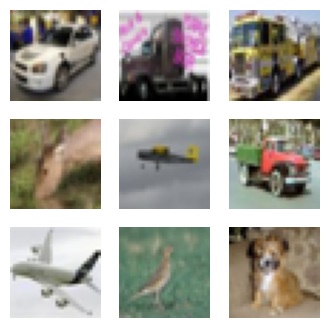

In [4]:
import matplotlib.pyplot as plt

def display_images(images):
    fig, axes=plt.subplots(3,3, figsize=(4,4))
    for i, ax in enumerate(axes.flat):
        if i<len(images):
            image=images[i].permute(1,2,0).numpy() # Rearrange dimensions for display
            ax.imshow(image)
            ax.axis('off')
    plt.show()

# get the first 9 images from the train_loader
data, target=next(iter(train_loader))
images=data[:9]

# display images using the helper function
display_images(images)

In [5]:
import torch.nn as nn
import torch.optim as optim

class ConvAE(nn.Module):
    def __init__(self, latent_dim=100):
        """
        We use 100-dimensional latent space and three convolutional layers that reduce the image dimension by a factor two every time.

        We achieve this by using a 4x4 kernel and stride size of 2.

        Starting with a 3-channel image, we use 64 learnable filters, each of size (3,4,4) one for each channel.

        We then pass the result through 128 learnable filters, each of size (64, 4, 4), and finally through 256 learnable filters of dimension (128, 4, 4).

        The output are 256 4x4 images, which are flattend into a single vector and passed through the fully connected layer. All of this happens in the encode() function.
        """
        super(ConvAE, self).__init__()

        # Encoder: Convolutions to extract features
        self.encoder=nn.Sequential(
            nn.Conv2d(3,64, kernel_size=4, stride=2, padding=1), # (B, 64, 16, 16)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # (B, 128, 8, 8)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # (B, 256, 4, 4)
            nn.ReLU(),
        )

        # Latent space
        self.fc=nn.Linear(256*4*4, latent_dim)

        # Decoder: Transposed convolutions for upsampling
        self.decoder_input=nn.Linear(latent_dim, 256*4*4)
        self.decoder=nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # (B, 64, 8, 8)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # (B, 32, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1), # (B, 3, 32, 32)
            nn.Sigmoid() # Output pixel values between 0 and 1
        )

    def encode(self, x):
        x=self.encoder(x)
        x=x.view(x.size(0), -1) # Flatten
        z=self.fc(x)
        return z

    def decode(self, z):
        """
        We first use a fully connected network to project from the latent dimension to a 256x4x4 pixels, which are then reshaped into 256 4x4 images and passed thorugh the convolutional layers.
        The result is again a 32x32 image.
        """
        x=self.decoder_input(z)
        x=x.view(z.size(0), 256, 4, 4) # Reshape to feature maps
        x=self.decoder(x)
        return x

    def forward(self, x):
        z=self.encode(x)
        recon_x=self.decode(z)
        return recon_x


# initialize model and optimizer

latent_dim=1024
model=ConvAE(latent_dim=latent_dim).to(device)
optimizer=optim.Adam(model.parameters(), lr=1e-3)

# Inspect the Model Size

In [6]:
def get_model_size(model):
    total_params=sum(p.numel() for p in model.parameters())
    return total_params

model_size=get_model_size(model)
print(f'Model size: {model_size} parameters')

Model size: 9711235 parameters


# Training

For the training loss, we can sum over the mean-square error over all pixels

In [7]:
import wandb
import torch.nn.functional as F

epochs = 20

# wandb_client=wandb.init(project='Implementation Auto Encoders', entity="urakiny", config={"epochs": epochs})


def loss_func(recon_x, x):
    recon_loss=F.mse_loss(recon_x, x, reduction='sum') # MSE for image reconstruction
    return recon_loss


for epoch in range(epochs):
    model.train()
    total_loss=0

    for batch_idx, (data, _) in enumerate(train_loader):
        data=data.to(device)

        optimizer.zero_grad()
        recon_data=model(data)
        loss=loss_func(recon_data, data)
        loss.backward()
        optimizer.step()

        total_loss+=loss.item()


    avg_loss = total_loss / len(train_loader.dataset)
    
    print(f'===> Epoch: {epoch+1}, Average training loess: {total_loss/ len(train_loader.dataset):.4f}')

    # Evaluation loop on validation dataset
    model.eval() # set the model to evaluation mode
    eval_loss=0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(svhn_loader):
            data = data.to(device)
            recon_data=model(data)
            loss=loss_func(recon_data, data)
            eval_loss+=loss.item()

    avg_eval_loss=eval_loss / len(svhn_loader.dataset)

    print(f'===> Epoch: {epoch+1}, Average evaluation loess: {avg_eval_loss:.4f}')
    

    # wandb_client.log({"epoch": epoch+1, "avg_loss": avg_loss})

# wandb_client.finish()

===> Epoch: 1, Average training loess: 50.4744
===> Epoch: 1, Average evaluation loess: 9.2546
===> Epoch: 2, Average training loess: 22.4499
===> Epoch: 2, Average evaluation loess: 7.0963
===> Epoch: 3, Average training loess: 17.1730
===> Epoch: 3, Average evaluation loess: 2.9915
===> Epoch: 4, Average training loess: 14.1251
===> Epoch: 4, Average evaluation loess: 2.5616
===> Epoch: 5, Average training loess: 12.6710
===> Epoch: 5, Average evaluation loess: 2.5835
===> Epoch: 6, Average training loess: 11.3564
===> Epoch: 6, Average evaluation loess: 2.6678
===> Epoch: 7, Average training loess: 10.1459
===> Epoch: 7, Average evaluation loess: 2.3861
===> Epoch: 8, Average training loess: 9.1340
===> Epoch: 8, Average evaluation loess: 1.5647
===> Epoch: 9, Average training loess: 8.4498
===> Epoch: 9, Average evaluation loess: 1.6880
===> Epoch: 10, Average training loess: 7.7887
===> Epoch: 10, Average evaluation loess: 1.4711
===> Epoch: 11, Average training loess: 7.2097
===>

# Testing the Autoencoder

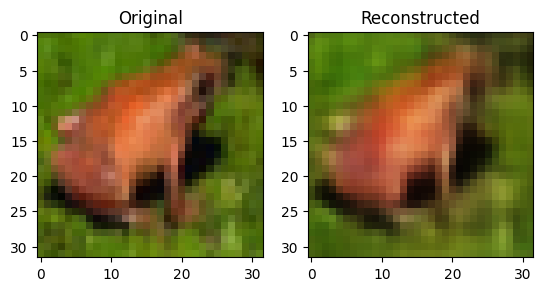

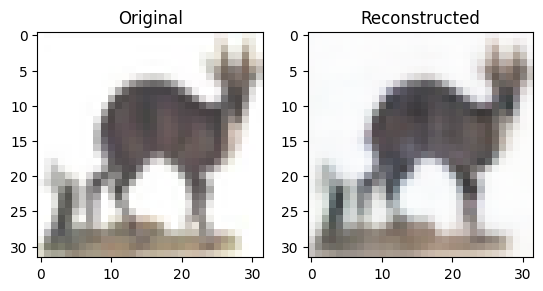

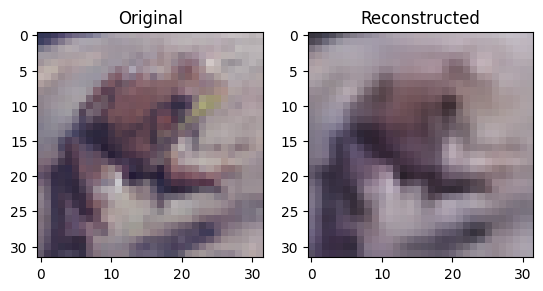

In [8]:
def show_images(original, reconstructed):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(original.permute(1, 2, 0).cpu().numpy())  # Convert tensor to image
    axes[0].set_title("Original")
    axes[1].imshow(reconstructed.permute(1, 2, 0).cpu().detach().numpy())
    axes[1].set_title("Reconstructed")
    plt.show()

for _ in range(3):
  # Test reconstruction on a sample
  test_img, _ = next(iter(train_loader))
  test_img = test_img.to(device)
  with torch.no_grad():
      reconstructed_img = model(test_img)[0]

  show_images(test_img[0], reconstructed_img)

# Acknowledgment

* https://www.kaggle.com/code/aisuko/fine-tune-openelm-270m-with-orpo
* https://medium.com/correll-lab/a-deep-dive-into-autoencoders-ae-vae-and-vq-vae-with-code-ba712b9210eb